# Isaac Rodríguez Bribiesca
# Tarea 3

## Ejercicio 1

In [0]:
import matplotlib.pyplot as plt
from scipy import spatial
import numpy as np

In [0]:
embeddings_dict = {}
with open("/content/drive/My Drive/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

### Ejercicio 1.1

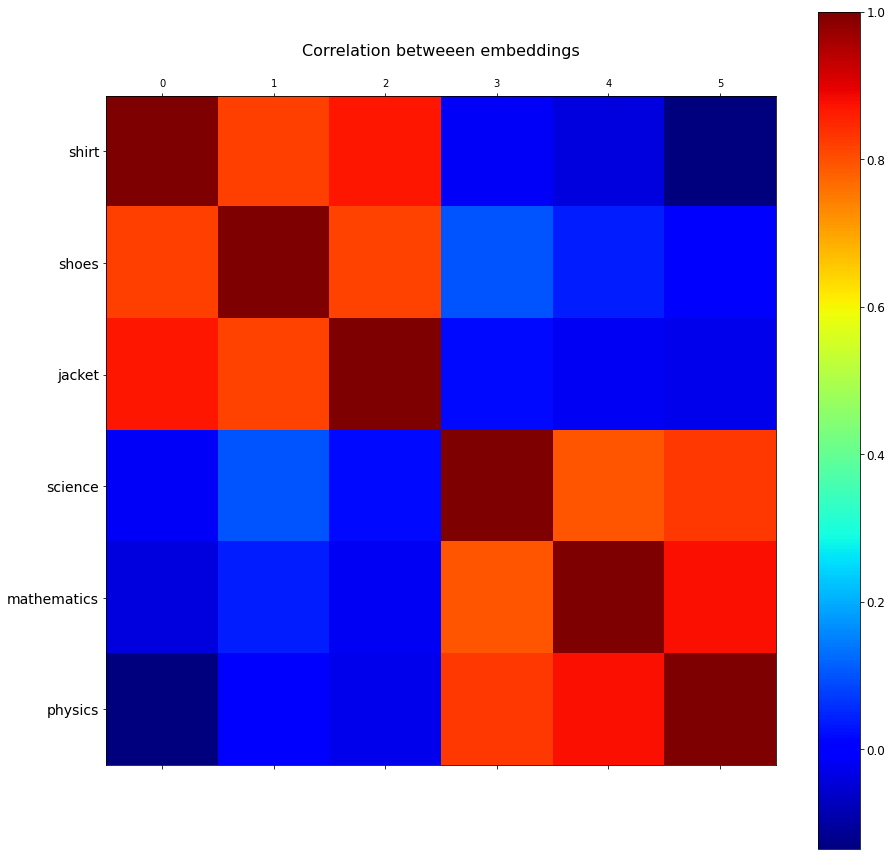

In [0]:
def showCorr(Corr, labels, cmap='jet'):
    f = plt.figure(figsize=(15, 15))
    plt.matshow(Corr, fignum=f.number, cmap=cmap)
    plt.yticks(range(len(labels)), labels, fontsize=14)
    axes = f.get_axes()[0]
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.title('Correlation betweeen embeddings', fontsize=16)
    plt.show()

names=['shirt', 'shoes', 'jacket', 'science', 'mathematics', 'physics']
embdd = np.array([embeddings_dict[name] for name in names])
Corr= np.corrcoef(embdd)
showCorr(Corr=Corr, labels=names, cmap='jet')

### Ejercicio 1.2

In [0]:
def find_k_neighbours_embeddings(embeddings_dict, word_embedding, k):
    sorted_embeddings = sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], word_embedding))
    return sorted_embeddings[:k]

In [0]:
# Ejemplo: Computer

find_k_neighbours_embeddings(embeddings_dict, embeddings_dict["computer"], 10)[1:]

['computers',
 'software',
 'technology',
 'electronic',
 'computing',
 'devices',
 'hardware',
 'internet',
 'applications']

In [0]:
# Ejemplo: Food

find_k_neighbours_embeddings(embeddings_dict, embeddings_dict["food"], 10)[1:]

['coffee',
 'products',
 'supplies',
 'supply',
 'meat',
 'foods',
 'bulk',
 'raw',
 'items']

In [0]:
# Ejemplo: Person

find_k_neighbours_embeddings(embeddings_dict, embeddings_dict["person"], 10)[1:]

['someone',
 'actually',
 'every',
 'knowing',
 'anyone',
 'same',
 'exactly',
 'another',
 'one']

### Ejercicio 1.3

In [0]:
# hombre es a padre como mujer es a: madre

word = embeddings_dict["father"] - embeddings_dict["male"] + embeddings_dict["woman"]
find_k_neighbours_embeddings(embeddings_dict, word, 5)[1]

'mother'

In [0]:
# caliente es a verano como frio es a: invierno

word = embeddings_dict["summer"] - embeddings_dict["hot"] + embeddings_dict["cold"]
find_k_neighbours_embeddings(embeddings_dict, word, 5)[1:]

['winter', 'during', 'beginning', 'spring']

### Comentarios

Para el ejercicio 1.1 se pudo observar de la matriz de correlación que se forman 2 bloques altamente correlacionados, uno con las palabras shoes, shirt y jacket, que tienen significados similares en cuanto a que son prendas de vestir. Mientras que el otro bloque altamente correlacionado corresponde a las palabras science, mathematics y physics, las cuales son similares en cuanto a que son áreas de estudio cercanas.

Del ejercicio 1.2, pude observar que palabras que se usan en contextos similares tienden a estar cerca unas de otras en su representación vectorial. Como en el caso de computadora, donde las palabras más cercanas hablan o se refieren a cosas de tecnología. Aunque también se observaron casos donde no necesariamente son palabras similares o sinónimos las que están más cercanas vectorialmente. Por ejemplo, una de las palabras más cercanas a person es every, la cual no tiene que ver con person semánticamente, pero son palabras que frecuentemente se usan juntas, como en "ervery person".

Finalmente, en el ejercicio 1.3 pude verificar que se pueden formar analogías con las representaciones vectoriales de las palabras. Lo cual es interesante ya que son operaciones lineales que se aplican a vectores generados por modelos no lineales.

Con esto se puede ver que los embeddings pueden ser de gran ayuda ya que son representaciones densas de baja dimensión, con una estructura vectorial donde palabras similares o que se usan en contextos similares aparecerán cerca en el espacio vectorial. A pesar de esto, también se observó que no siempre se cumple que palabras cercanas vectorialmente serán similares.

## Ejercicio 2

In [2]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.python.client import device_lib
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import optimizers
from keras import models
from keras import layers
import seaborn as sns
import numpy as np
import keras
import time

(X_train_digits, y_train_digits), (X_test_digits, y_test_digits) = mnist.load_data()
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15621176440203191462
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6823240624810829932
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2719089877333998443
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15268029026244581078
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


### Red neuronal con 2 ramas (densa y convolucional). Digit-MNIST

In [29]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, LeakyReLU, MaxPooling2D
from keras.utils import plot_model
from keras.models import Model
from keras import backend as K

train_images = X_train_digits.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test_digits.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(y_train_digits)
test_labels  = to_categorical(y_test_digits)

img_dim     = (28, 28, 1,)

# Inputs

input1 = Input(shape=img_dim)

# CNN branch

x1 = input1
x1 = Conv2D(filters  = 32, 
            kernel_size = 3,
            strides     =  2,
            padding     = 'same',
            activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(filters  = 64, 
            kernel_size = 3,
            strides     =  2,
            padding     = 'same',
            activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(filters  = 64, 
            kernel_size = 3,
            strides     =  2,
            padding     = 'same',
            activation='relu')(x1)
x1=Flatten()(x1)
x1out = Dense(units=32, activation='relu')(x1)

# Dense branch

x2    = Flatten()(input1)
x2    = Dense(units=128, activation='relu')(x2)
x2    = Dense(units=64, activation='relu')(x2)
x2out = Dense(units=16, activation='relu')(x2)
shape_x2out = K.int_shape(x2out)

# Union of CNN and Dense branches

x12 = keras.layers.Concatenate()([x1out, x2out])

# Output layer

y = Dense(10, activation='softmax')(x12)

# Model

model_2Branch = Model(inputs=[input1], 
                          outputs=[y], 
                          name='multiOut')

model_2Branch.compile(optimizer='rmsprop',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

model_2Branch.summary()


Model: "multiOut"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 14, 14, 32)   320         input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 32)     0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 4, 4, 64)     18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________

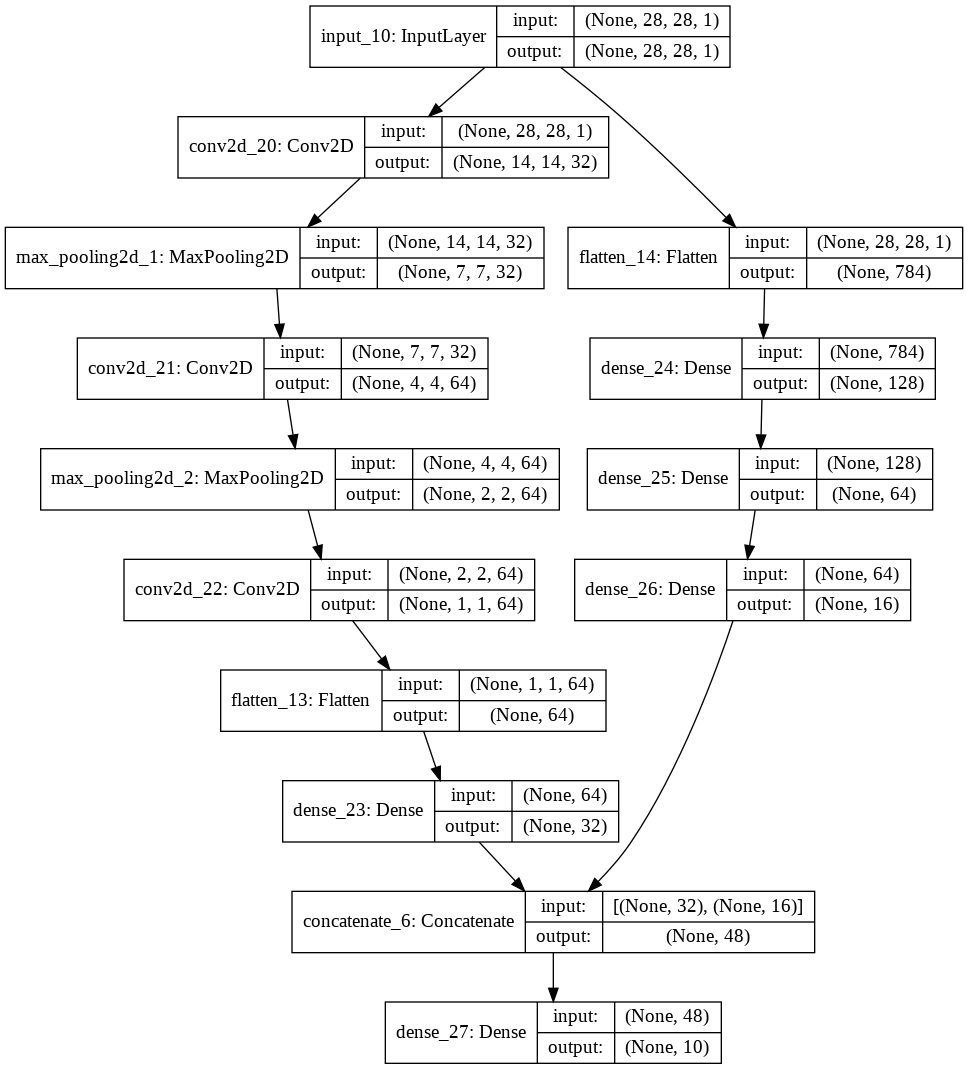

In [30]:
plot_model(model_2Branch, to_file='model_multipleBranch.png',show_shapes=True, show_layer_names=True)

In [31]:
tic=time.time()

history = model_2Branch.fit(x=train_images, 
                 y=train_labels, 
                 validation_split=.2,
                 epochs=15,
                 shuffle=True,
                 batch_size=128,
                 verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 3s - loss: 0.4170 - acc: 0.8729 - val_loss: 0.1706 - val_acc: 0.9512
Epoch 2/15
 - 2s - loss: 0.1456 - acc: 0.9552 - val_loss: 0.1021 - val_acc: 0.9695
Epoch 3/15
 - 2s - loss: 0.0926 - acc: 0.9713 - val_loss: 0.1025 - val_acc: 0.9692
Epoch 4/15
 - 2s - loss: 0.0676 - acc: 0.9783 - val_loss: 0.0954 - val_acc: 0.9729
Epoch 5/15
 - 2s - loss: 0.0524 - acc: 0.9834 - val_loss: 0.0809 - val_acc: 0.9765
Epoch 6/15
 - 2s - loss: 0.0413 - acc: 0.9871 - val_loss: 0.0649 - val_acc: 0.9811
Epoch 7/15
 - 2s - loss: 0.0335 - acc: 0.9892 - val_loss: 0.0663 - val_acc: 0.9814
Epoch 8/15
 - 2s - loss: 0.0271 - acc: 0.9913 - val_loss: 0.0719 - val_acc: 0.9819
Epoch 9/15
 - 2s - loss: 0.0219 - acc: 0.9931 - val_loss: 0.0734 - val_acc: 0.9803
Epoch 10/15
 - 2s - loss: 0.0175 - acc: 0.9943 - val_loss: 0.0698 - val_acc: 0.9831
Epoch 11/15
 - 2s - loss: 0.0145 - acc: 0.9953 - val_loss: 0.0689 - val_acc: 0.9831
Epoch 12/15
 - 2s - loss: 0.0118 - 

In [0]:
history_dict = history.history
dictkeys=list(history_dict.keys())

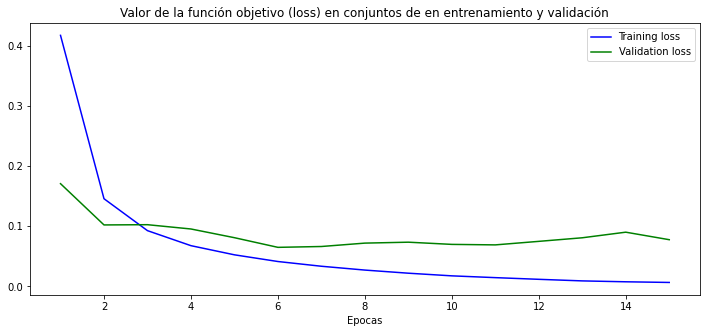

In [33]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

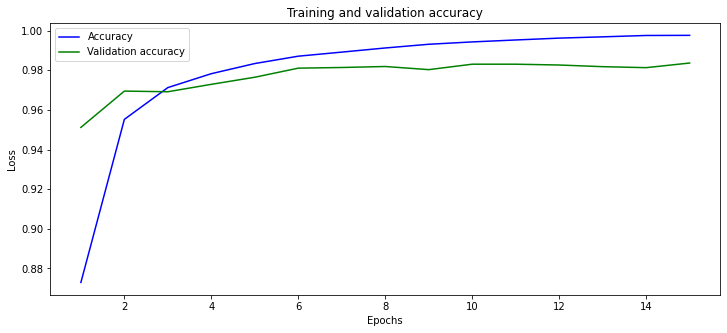

In [34]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

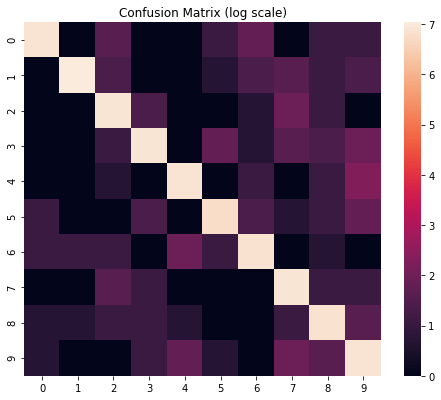

In [35]:
y_pred = model_2Branch.predict(test_images).squeeze()
y_test_label = np.argmax(test_labels,1) 
y_pred_label = np.argmax(y_pred,1)
C=confusion_matrix(y_pred_label, y_test_label)
plt.figure(figsize=(8,6.5))
plt.title('Confusion Matrix (log scale)')
sns.heatmap(np.log(C+1), xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.show()

In [36]:
print("Precision test dataset: ", precision_score(y_pred_label, y_test_label, average='macro'))
print("Recall test dataset: ", recall_score(y_pred_label, y_test_label,  average='macro'))
print("F1 Score test dataset: ", f1_score(y_pred_label, y_test_label,  average='macro'))

Precision test dataset:  0.9848071002394635
Recall test dataset:  0.9848516010569393
F1 Score test dataset:  0.9848116716985358


### Red neuronal con 2 ramas (densa y convolucional). Fashion-MNIST

In [7]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, LeakyReLU, MaxPooling2D
from keras.utils import plot_model
from keras.models import Model
from keras import backend as K

train_images = X_train_fashion.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test_fashion.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(y_train_fashion)
test_labels  = to_categorical(y_test_fashion)

img_dim     = (28, 28, 1,)

# Inputs

input1 = Input(shape=img_dim)

# CNN branch

x1 = input1
x1 = Conv2D(filters  = 32, 
            kernel_size = 3,
            strides     =  2,
            padding     = 'same',
            activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(filters  = 64, 
            kernel_size = 3,
            strides     =  2,
            padding     = 'same',
            activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(filters  = 64, 
            kernel_size = 3,
            strides     =  2,
            padding     = 'same',
            activation='relu')(x1)
x1=Flatten()(x1)
x1out = Dense(units=32, activation='relu')(x1)

# Dense branch

x2    = Flatten()(input1)
x2    = Dense(units=128, activation='relu')(x2)
x2    = Dense(units=64, activation='relu')(x2)
x2out = Dense(units=16, activation='relu')(x2)
shape_x2out = K.int_shape(x2out)

# Union of CNN and Dense branches

x12 = keras.layers.Concatenate()([x1out, x2out])

# Output layer

y = Dense(10, activation='softmax')(x12)

# Model

model_2Branch = Model(inputs=[input1], 
                          outputs=[y], 
                          name='multiOut')

model_2Branch.compile(optimizer='rmsprop',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

tic=time.time()

history = model_2Branch.fit(x=train_images, 
                 y=train_labels, 
                 validation_split=.2,
                 epochs=15,
                 shuffle=True,
                 batch_size=128,
                 verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 3s - loss: 0.6365 - acc: 0.7777 - val_loss: 0.4436 - val_acc: 0.8408
Epoch 2/15
 - 3s - loss: 0.4116 - acc: 0.8509 - val_loss: 0.4105 - val_acc: 0.8540
Epoch 3/15
 - 3s - loss: 0.3495 - acc: 0.8734 - val_loss: 0.3540 - val_acc: 0.8698
Epoch 4/15
 - 3s - loss: 0.3124 - acc: 0.8859 - val_loss: 0.3090 - val_acc: 0.8898
Epoch 5/15
 - 3s - loss: 0.2878 - acc: 0.8949 - val_loss: 0.3025 - val_acc: 0.8891
Epoch 6/15
 - 3s - loss: 0.2659 - acc: 0.9025 - val_loss: 0.3007 - val_acc: 0.8927
Epoch 7/15
 - 3s - loss: 0.2519 - acc: 0.9065 - val_loss: 0.2946 - val_acc: 0.8976
Epoch 8/15
 - 3s - loss: 0.2367 - acc: 0.9137 - val_loss: 0.3096 - val_acc: 0.8903
Epoch 9/15
 - 3s - loss: 0.2231 - acc: 0.9185 - val_loss: 0.2762 - val_acc: 0.9042
Epoch 10/15
 - 3s - loss: 0.2121 - acc: 0.9217 - val_loss: 0.2862 - val_acc: 0.9017
Epoch 11/15
 - 3s - loss: 0.2021 - acc: 0.9252 - val_loss: 0.2727 - val_acc: 0.9057
Epoch 12/15
 - 3s - loss: 0.1913 - 

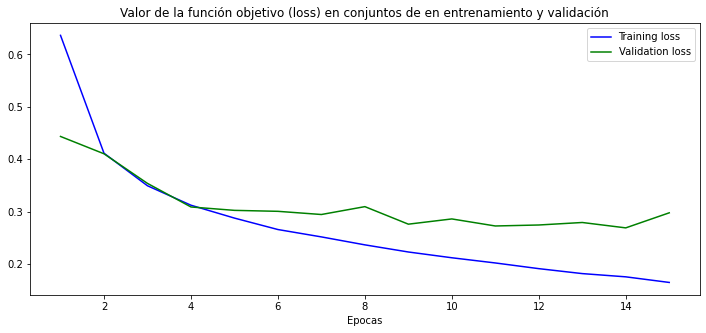

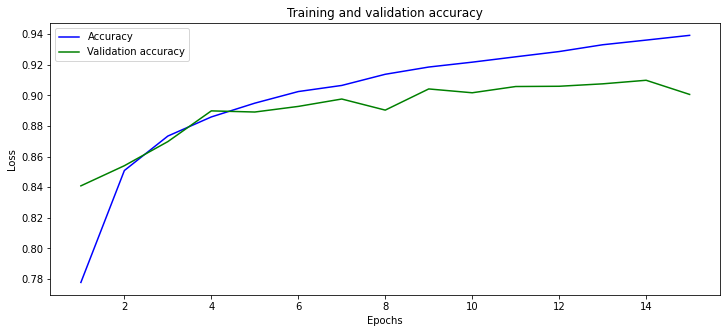

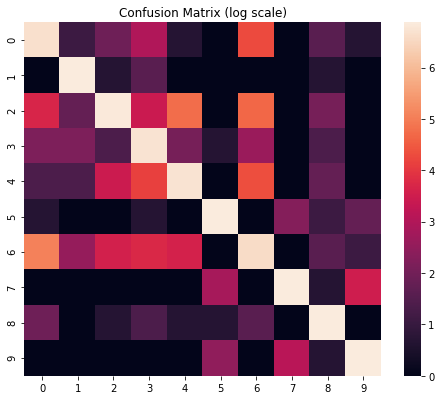

In [8]:
history_dict = history.history
dictkeys=list(history_dict.keys())

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()
plt.show()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = model_2Branch.predict(test_images).squeeze()
y_test_label = np.argmax(test_labels,1) 
y_pred_label = np.argmax(y_pred,1)
C=confusion_matrix(y_pred_label, y_test_label)
plt.figure(figsize=(8,6.5))
plt.title('Confusion Matrix (log scale)')
sns.heatmap(np.log(C+1), xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.show()

In [9]:
print("Precision test dataset: ", precision_score(y_pred_label, y_test_label, average='macro'))
print("Recall test dataset: ", recall_score(y_pred_label, y_test_label,  average='macro'))
print("F1 Score test dataset: ", f1_score(y_pred_label, y_test_label,  average='macro'))

Precision test dataset:  0.8957
Recall test dataset:  0.9002777395976624
F1 Score test dataset:  0.8964426011613342


### Red neuronal sólo capas densas. Digit-MNIST

In [0]:
train_images = X_train_digits.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images  = X_test_digits.reshape((10000, 28 * 28))
test_images  = test_images.astype('float32') / 255

numIm, szIm  = train_images.shape

train_labels = to_categorical(y_train_digits)
test_labels  = to_categorical(y_test_digits)

In [0]:
nn = models.Sequential()

nn.add(layers.Dense(units=512,
                    activation='relu',
                    input_shape=(szIm,)))

nn.add(layers.Dense(units=256,
                    activation='relu',
                    input_shape=(szIm,)))

nn.add(layers.Dense(units=10, activation='softmax'))

In [0]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [0]:
# parametros de metodo de optimizacion
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# parametros del procedimiento de aprendizaje
nn.compile(optimizer=sgd,
           loss='categorical_crossentropy',
           metrics=['accuracy'])

In [0]:
tic=time.time()

history = nn.fit(x=train_images, 
                 y=train_labels, 
                 validation_split=.2,
                 epochs=15,
                 shuffle=True,
                 batch_size=128,
                 verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 2s - loss: 0.4757 - acc: 0.8675 - val_loss: 0.2413 - val_acc: 0.9310
Epoch 2/15
 - 2s - loss: 0.2161 - acc: 0.9384 - val_loss: 0.1787 - val_acc: 0.9513
Epoch 3/15
 - 2s - loss: 0.1611 - acc: 0.9542 - val_loss: 0.1471 - val_acc: 0.9586
Epoch 4/15
 - 2s - loss: 0.1271 - acc: 0.9646 - val_loss: 0.1260 - val_acc: 0.9644
Epoch 5/15
 - 2s - loss: 0.1047 - acc: 0.9704 - val_loss: 0.1227 - val_acc: 0.9647
Epoch 6/15
 - 2s - loss: 0.0863 - acc: 0.9762 - val_loss: 0.1062 - val_acc: 0.9688
Epoch 7/15
 - 2s - loss: 0.0738 - acc: 0.9793 - val_loss: 0.0984 - val_acc: 0.9710
Epoch 8/15
 - 2s - loss: 0.0625 - acc: 0.9829 - val_loss: 0.0926 - val_acc: 0.9728
Epoch 9/15
 - 2s - loss: 0.0542 - acc: 0.9856 - val_loss: 0.0887 - val_acc: 0.9746
Epoch 10/15
 - 2s - loss: 0.0468 - acc: 0.9875 - val_loss: 0.0880 - val_acc: 0.9737
Epoch 11/15
 - 2s - loss: 0.0407 - acc: 0.9896 - val_loss: 0.0856 - val_acc: 0.9748
Epoch 12/15
 - 2s - loss: 0.0351 - 

In [0]:
history_dict = history.history
dictkeys=list(history_dict.keys())

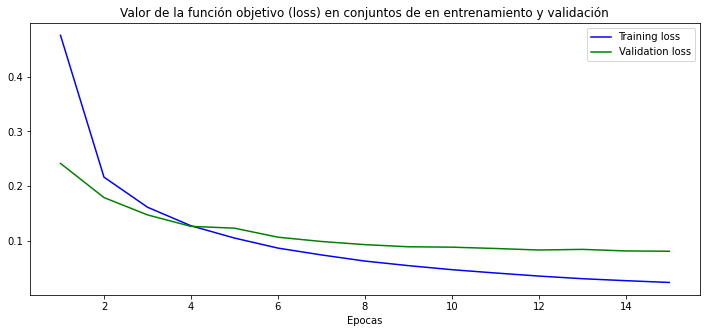

In [0]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

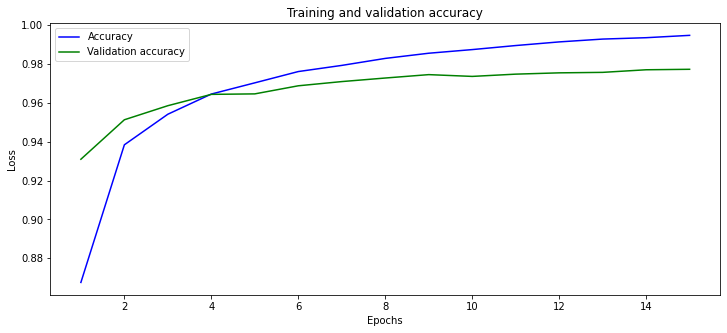

In [0]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

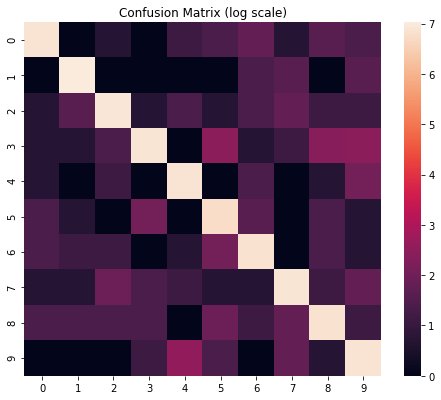

In [0]:
y_pred = nn.predict(test_images).squeeze()
y_test_label = np.argmax(test_labels,1) 
y_pred_label = np.argmax(y_pred,1)
C=confusion_matrix(y_pred_label, y_test_label)
plt.figure(figsize=(8,6.5))
plt.title('Confusion Matrix (log scale)')
sns.heatmap(np.log(C+1), xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.show()

In [0]:
print("Precision test dataset: ", precision_score(y_pred_label, y_test_label, average='macro'))
print("Recall test dataset: ", recall_score(y_pred_label, y_test_label,  average='macro'))
print("F1 Score test dataset: ", f1_score(y_pred_label, y_test_label,  average='macro'))

Precision test dataset:  0.9780868293268208
Recall test dataset:  0.9783089806065748
F1 Score test dataset:  0.97817248284411


### Red neuronal sólo capas densas. Fashion-MNIST

In [13]:
train_images = X_train_fashion.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images  = X_test_fashion.reshape((10000, 28 * 28))
test_images  = test_images.astype('float32') / 255

numIm, szIm  = train_images.shape

train_labels = to_categorical(y_train_fashion)
test_labels  = to_categorical(y_test_fashion)

# Build model

nn = models.Sequential()

nn.add(layers.Dense(units=512,
                    activation='relu',
                    input_shape=(szIm,)))

nn.add(layers.Dense(units=256,
                    activation='relu',
                    input_shape=(szIm,)))

nn.add(layers.Dense(units=10, activation='softmax'))

# parametros de metodo de optimizacion
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# parametros del procedimiento de aprendizaje
nn.compile(optimizer=sgd,
           loss='categorical_crossentropy',
           metrics=['accuracy'])

# Train model

tic=time.time()

history = nn.fit(x=train_images, 
                 y=train_labels, 
                 validation_split=.2,
                 epochs=15,
                 shuffle=True,
                 batch_size=128,
                 verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 2s - loss: 0.6127 - acc: 0.7913 - val_loss: 0.4714 - val_acc: 0.8325
Epoch 2/15
 - 2s - loss: 0.4266 - acc: 0.8492 - val_loss: 0.4127 - val_acc: 0.8580
Epoch 3/15
 - 2s - loss: 0.3814 - acc: 0.8658 - val_loss: 0.4003 - val_acc: 0.8598
Epoch 4/15
 - 2s - loss: 0.3568 - acc: 0.8727 - val_loss: 0.3734 - val_acc: 0.8665
Epoch 5/15
 - 2s - loss: 0.3351 - acc: 0.8814 - val_loss: 0.3587 - val_acc: 0.8736
Epoch 6/15
 - 2s - loss: 0.3176 - acc: 0.8861 - val_loss: 0.3432 - val_acc: 0.8748
Epoch 7/15
 - 2s - loss: 0.3037 - acc: 0.8905 - val_loss: 0.3441 - val_acc: 0.8727
Epoch 8/15
 - 2s - loss: 0.2913 - acc: 0.8954 - val_loss: 0.3310 - val_acc: 0.8828
Epoch 9/15
 - 2s - loss: 0.2799 - acc: 0.8991 - val_loss: 0.3363 - val_acc: 0.8782
Epoch 10/15
 - 2s - loss: 0.2706 - acc: 0.9024 - val_loss: 0.3195 - val_acc: 0.8832
Epoch 11/15
 - 2s - loss: 0.2599 - acc: 0.9062 - val_loss: 0.3142 - val_acc: 0.8862
Epoch 12/15
 - 2s - loss: 0.2527 - 

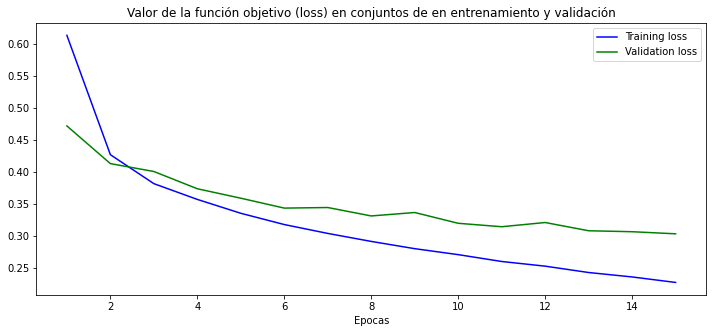

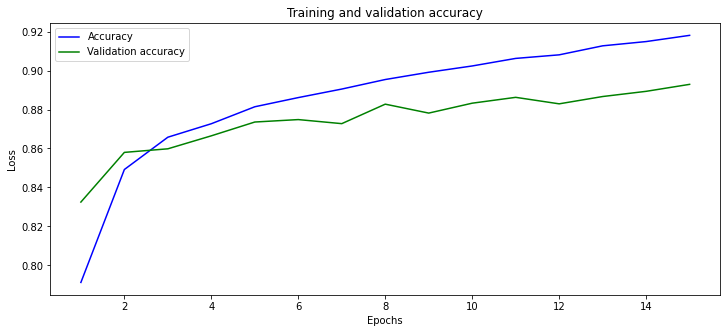

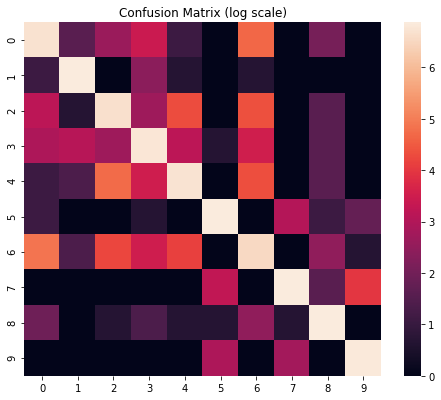

In [14]:
history_dict = history.history
dictkeys=list(history_dict.keys())

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()
plt.show()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = nn.predict(test_images).squeeze()
y_test_label = np.argmax(test_labels,1) 
y_pred_label = np.argmax(y_pred,1)
C=confusion_matrix(y_pred_label, y_test_label)
plt.figure(figsize=(8,6.5))
plt.title('Confusion Matrix (log scale)')
sns.heatmap(np.log(C+1), xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.show()

In [15]:
print("Precision test dataset: ", precision_score(y_pred_label, y_test_label, average='macro'))
print("Recall test dataset: ", recall_score(y_pred_label, y_test_label,  average='macro'))
print("F1 Score test dataset: ", f1_score(y_pred_label, y_test_label,  average='macro'))

Precision test dataset:  0.8809000000000001
Recall test dataset:  0.881842409511739
F1 Score test dataset:  0.8811898960701724


### Red neuronal convolucional. Digits-MNIST

In [0]:
train_images = X_train_digits.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test_digits.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(y_train_digits)
test_labels  = to_categorical(y_test_digits)

In [0]:
convNN = models.Sequential()

convNN.add(layers.Conv2D(filters=32, kernel_size =(3, 3), activation  ='relu', input_shape =(28, 28, 1)))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(layers.Flatten())
convNN.add(layers.Dense(units=64, activation='relu'))
convNN.add(layers.Dense(units=10, activation='softmax'))

In [98]:
convNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [0]:
# parametros de metodo de optimizacion
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# parametros del procedimiento de aprendizaje
convNN.compile(optimizer=sgd,
           loss='categorical_crossentropy',
           metrics=['accuracy'])

In [106]:
import time
tic = time.time()

history = convNN.fit(x = train_images,
                     y = train_labels,
                     validation_split=.2,
                     epochs=7,
                     shuffle=True,
                     batch_size=64,
                     verbose=2)

print('seconds=', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/7
 - 5s - loss: 0.2998 - acc: 0.9093 - val_loss: 0.0884 - val_acc: 0.9736
Epoch 2/7
 - 4s - loss: 0.0752 - acc: 0.9769 - val_loss: 0.0672 - val_acc: 0.9786
Epoch 3/7
 - 4s - loss: 0.0533 - acc: 0.9831 - val_loss: 0.0686 - val_acc: 0.9796
Epoch 4/7
 - 4s - loss: 0.0423 - acc: 0.9870 - val_loss: 0.0541 - val_acc: 0.9841
Epoch 5/7
 - 4s - loss: 0.0342 - acc: 0.9892 - val_loss: 0.0539 - val_acc: 0.9859
Epoch 6/7
 - 4s - loss: 0.0298 - acc: 0.9902 - val_loss: 0.0484 - val_acc: 0.9862
Epoch 7/7
 - 4s - loss: 0.0243 - acc: 0.9920 - val_loss: 0.0492 - val_acc: 0.9866
seconds= 30.68079900741577


In [0]:
history_dict = history.history
dictkeys=list(history_dict.keys())

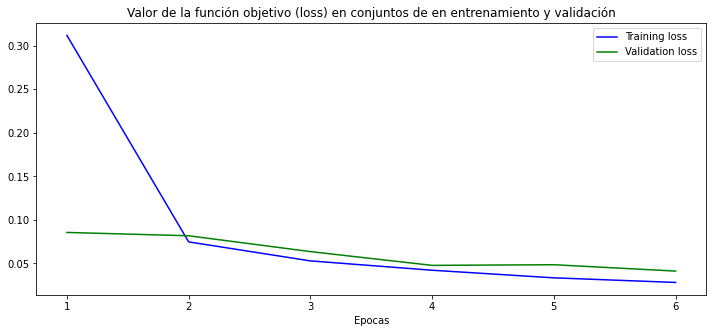

In [102]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

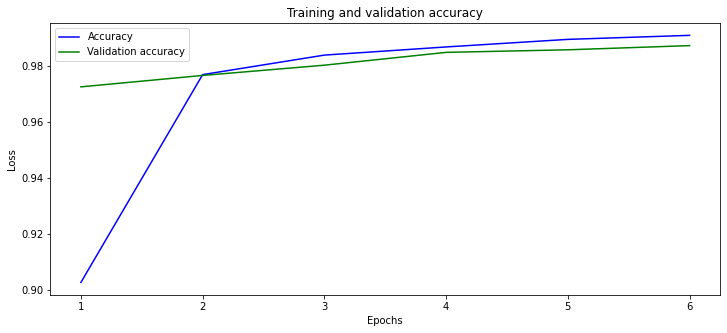

In [103]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

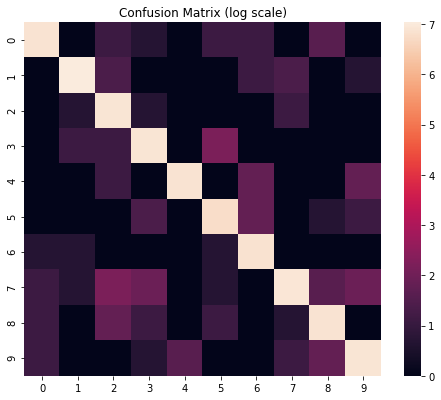

In [107]:
y_pred = convNN.predict(test_images).squeeze()
y_test_label = np.argmax(test_labels,1) 
y_pred_label = np.argmax(y_pred,1)
C=confusion_matrix(y_pred_label, y_test_label)
plt.figure(figsize=(8,6.5))
plt.title('Confusion Matrix (log scale)')
sns.heatmap(np.log(C+1), xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.show()

In [108]:
print("Precision test dataset: ", precision_score(y_pred_label, y_test_label, average='macro'))
print("Recall test dataset: ", recall_score(y_pred_label, y_test_label,  average='macro'))
print("F1 Score test dataset: ", f1_score(y_pred_label, y_test_label,  average='macro'))

Precision test dataset:  0.9882859533506947
Recall test dataset:  0.988446901078506
F1 Score test dataset:  0.9883435275288817


### Red neuronal convolucional. Fashion-MNIST

In [19]:
train_images = X_train_fashion.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test_fashion.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(y_train_fashion)
test_labels  = to_categorical(y_test_fashion)

# Build model

convNN = models.Sequential()

convNN.add(layers.Conv2D(filters=32, kernel_size =(3, 3), activation  ='relu', input_shape =(28, 28, 1)))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(layers.Flatten())
convNN.add(layers.Dense(units=64, activation='relu'))
convNN.add(layers.Dense(units=10, activation='softmax'))

# parametros de metodo de optimizacion
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# parametros del procedimiento de aprendizaje
convNN.compile(optimizer=sgd,
           loss='categorical_crossentropy',
           metrics=['accuracy'])

import time
tic = time.time()

history = convNN.fit(x = train_images,
                     y = train_labels,
                     validation_split=.2,
                     epochs=6,
                     shuffle=True,
                     batch_size=64,
                     verbose=2)

print('seconds=', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/6
 - 5s - loss: 0.7214 - acc: 0.7279 - val_loss: 0.4912 - val_acc: 0.8228
Epoch 2/6
 - 4s - loss: 0.4344 - acc: 0.8420 - val_loss: 0.4105 - val_acc: 0.8477
Epoch 3/6
 - 4s - loss: 0.3687 - acc: 0.8642 - val_loss: 0.3631 - val_acc: 0.8685
Epoch 4/6
 - 4s - loss: 0.3294 - acc: 0.8798 - val_loss: 0.3358 - val_acc: 0.8758
Epoch 5/6
 - 4s - loss: 0.3016 - acc: 0.8902 - val_loss: 0.3170 - val_acc: 0.8833
Epoch 6/6
 - 4s - loss: 0.2833 - acc: 0.8963 - val_loss: 0.3078 - val_acc: 0.8872
seconds= 26.400611877441406


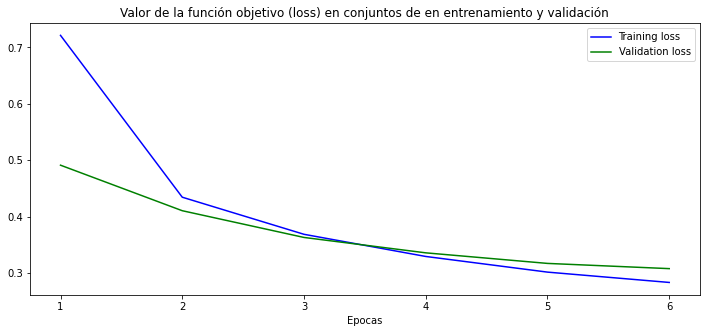

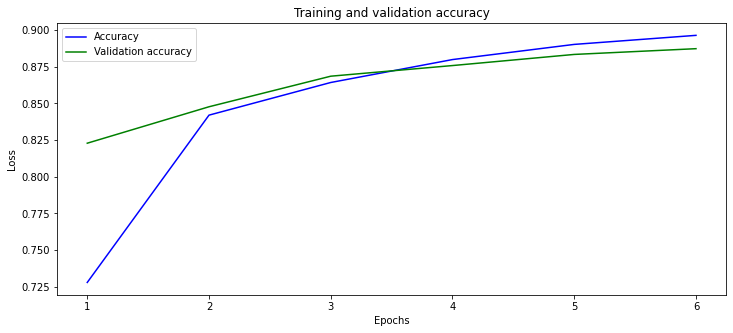

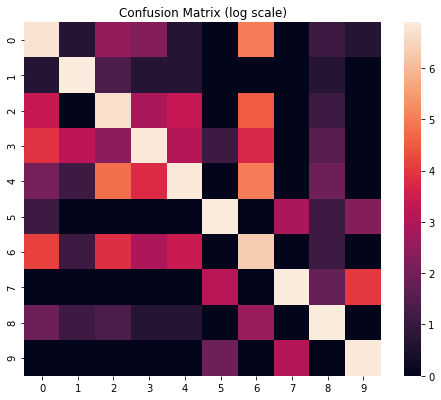

In [20]:
history_dict = history.history
dictkeys=list(history_dict.keys())

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()
plt.show()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = convNN.predict(test_images).squeeze()
y_test_label = np.argmax(test_labels,1) 
y_pred_label = np.argmax(y_pred,1)
C=confusion_matrix(y_pred_label, y_test_label)
plt.figure(figsize=(8,6.5))
plt.title('Confusion Matrix (log scale)')
sns.heatmap(np.log(C+1), xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.show()

In [21]:
print("Precision test dataset: ", precision_score(y_pred_label, y_test_label, average='macro'))
print("Recall test dataset: ", recall_score(y_pred_label, y_test_label,  average='macro'))
print("F1 Score test dataset: ", f1_score(y_pred_label, y_test_label,  average='macro'))

Precision test dataset:  0.885
Recall test dataset:  0.8860856416359612
F1 Score test dataset:  0.8825035760052067


## Resultados y Conclusiones

1. Resultado red neuronal con ramas.

  Dataset de Digits-MNIST:

  *   Accuracy: 0.9837
  *   F1-SCore: 0.9848

  Dataset de Fashion-MNIST:

  *   Accuracy: 0.9006
  *   F1-SCore: 0.8964

2. Resultado red convolucional.

  Dataset de Digits-MNIST:

  *   Accuracy: 0.9866
  *   F1-SCore: 0.9883

  Dataset de Fashion-MNIST:

  *   Accuracy: 0.8929
  *   F1-SCore: 0.8811

3. Resultado red neuronal con capas densas

  Dataset de Digits-MNIST:

  *   Accuracy: 0.9773
  *   F1-SCore: 0.9781

  Dataset de Fashion-MNIST:

  *   Accuracy: 0.8872
  *   F1-SCore: 0.8825

De los resultados se puede observar que la red neuronal con ramas tuvo el mejor desempeño para el dataset de Fashion-MNIST, mientras que la red convolucional tuvo el mejor desempeño para el datset de Digits-MNIST. También cabe resaltar que para los resultados obtenidos la red neuronal con ramas se entrenó por 15 épocas mientras que la red convolucional sólo se entrenó con 7 épocas.

Mientras que el modelo de capas densas tuvo el pero desempeño, esto debido a que al redimensionar la imagen a un vector, se pierde información de su estrucutra.

Para el caso de la red con ramas y la convolucional se obtuvieron resultados similares ya que la red con ramas también cuenta con una parte convolucional, lo cual la hace muy parecida a una sólamente convolucional, con la información extra que pudiera dar la rama con capas densas.

Pude notar que las redes con ramas pueden ser de utilidad ya que distintos tipos de capas capturan y extraen información de manera diferente y dependiendo de los datos que se tengan y el problema que se quiera resolver, este tipo de redes pueden dar una mayor flexibilidad, aunque también se debe cuidar que no se esté introduciendo información redundante que pueda meter más ruido al modelo.